In [1]:
### Essentials
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime, timedelta

#Plotting
%matplotlib widget
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors
from matplotlib.colors import ListedColormap, BoundaryNorm, TwoSlopeNorm
import matplotlib.ticker as ticker
from matplotlib import patches
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D

#Oceanography tools
import gsw # https://teos-10.github.io/GSW-Python/gsw_flat.html
from iapws import iapws95
from physoce import tseries as ts
from physoce import stats as pStat
from physoce import oceans as oc

#Scipy
from scipy.signal import welch 
from scipy.stats import chi2 
from scipy.special import gamma
from scipy import stats
from scipy import signal
from scipy.signal import periodogram
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit
from scipy import integrate
from scipy.stats.distributions import  t

#Mapping tools
from cartopy.io import shapereader
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cmocean import cm

#Custom function packages
import vector_tools as vt
import Plot_tools as pt

# Import Data

In [2]:
#Import data
ADV1data = xr.open_dataset('ADV/adv1_final.nc')
ADV2data = xr.open_dataset('ADV/adv2_final.nc')
TEMPdata = xr.open_dataset('Temperature/temp_final.nc')

# Estimating Wave Parameters and Turbulent Dissipation

The ADV recorded presure and 3-dimensional velocity at 32Hz for 20-minute bursts every hour, resulting in 38400 total samples per burst. Any data points with a single beam correlation under 60%, a signal-to-noise ratio below 10dB, or an instrument tilt more than 5 degrees were removed. After removing poor quality data, the remaining velocity points were run through the "expanding ellipse" despiking algorithm used in Wheeler & Giddings (2023). The remaining gaps in the time series were repaired using methods outlined in Feddersen (2010), where gaps within 1 second in length are linearly interpolated and longer gaps are averaged using the original data. All despiked and repaired data are labelled as "unoriginal", where a ratio of unoriginal samples to total samples can be used to assess the general quality of each burst. 

To estimate wave parameters, pressure spectra were calculated for each burst. Each burst was linearly detrended, split into 60 second segments, and ensemble averaged using a Hann window with 50% overlap, resulting in 107 degrees of freedom (Thomson & Emery, 2014). Following the methods described in Jones and Monosmith (2007), pressure spectra ($S_{pp}$) were converted to surface elevation spectra ($S_{\eta\eta}$) via linear wave theory and used to extrapolate an $\omega^{-4}$ wave model tail beyond this ADV's pressure sensor noise floor at around 0.4Hz. Significant wave height ($H_{s}$) and average wave period ($T_{avg}$) were estimated from $S_{\eta\eta}$ with the $\omega^{-4}$ tail via the methods described in Jones and Monosmith (2007). The peak wave period ($T_{peak}$) was defined as the period where $S_{\eta\eta}$ was largest.

Turbulent kinetic energy dissipation rate ($\epsilon$) was estimated using the power law fit of the vertical velocity spectra ($S_{ww}(\omega)$) within the inertial subrange (ISR) with the smallest least square error from -5/3 slope (Kolmogorov's Law). The lower frequency limits of the ISR were determined by converting $S_{pp}$ to vertical velocity spectra ($S_{w'w'}$) via linear wave theory, to show the surface gravity wave signal. The discrete boundary was defined as the cutoff frequency of the $S_{pp}$ noise floor, since this is where $S_{w'w'}$ begins to diverge from the velocity spectra. The upper frequency cutoff was defined as the beginning of the $S_{ww}$ noise floor at 3.5Hz. Within these boundaries, a power law was fit to all combinations of frequencies, requiring a minimum frequency range of 1Hz. $\epsilon$ was calculated for each of the fits via the following equation from Gerbi et al. (2009):

$\epsilon$ = $\Biggl \langle \left[ \frac{S_{ww}(\omega) \omega^\frac{5}{3}}{\alpha J_{33}(\omega)} \right] ^\frac{3}{2} \Biggr \rangle$

where $S_{ww}(\omega)$ is the vertical velocity spectra, $\omega$ is the radian frequency, $\alpha$ is Komogorov's constant of 1.5, and $J_{33}(\omega)$ is an integral over 3D wavenumber space that depends on the mean flow and wave-orbital velocities derived, and the angle brackets represent the mean over the frequencies in the ISR. Each estimate of epsilon is run through a series of tests derived from multiple studies (Jones & Monosmith (2008); Gerbi et al. (2009); Feddersen (2010); Wheeler & Giddings (2023)) in order to generate robust values of $\epsilon$ that are accepted by a broad range of requirements. Any estimate of $\epsilon$ that doesn't meet all requirements is rejected. From the remaining estimates, the power law fit with the least squares error from Komogorov's Law is selected as the final estimate. This entire process, as well as all equations used, are expanded upon in the appendix.

In [ ]:
eps1_test = vt.ADV_spectraDS(ADV1data,TEMPdata,segLength=60,window='hann',pNoisefloorFreq=.4,vNoisefloorFreq=3.5,wtNoisefloorFactor=12,wtPeakwaveFactor=1.1,wtSlope = -4,minimumGap = 1)
eps2_test = vt.ADV_spectraDS(ADV2data,TEMPdata,segLength=60,window='hann',pNoisefloorFreq=.4,vNoisefloorFreq=3.5,wtNoisefloorFactor=12,wtPeakwaveFactor=1.1,wtSlope = -4,minimumGap = 1)

In [33]:
eps1_test.to_netcdf('Dissipation/eps1_final2.nc')
eps2_test.to_netcdf('Dissipation/eps2_final2.nc')

# Plotting the Spectra

In [2]:
#Import data
#eps1 = xr.open_dataset('Dissipation/eps1_final2.nc')
#eps2 = xr.open_dataset('Dissipation/eps2_final2.nc')

eps1 = xr.open_dataset('Dissipation/eps1_final.nc')
eps2 = xr.open_dataset('Dissipation/eps2_final.nc')

In [26]:
#Find the absolute best values of epsilon
epsDS = eps1.copy(deep=True)
bl = epsDS.BurstCounter.where((epsDS.UpOrigRatio<=.2)&(((np.round(epsDS.R_ratio,1) >= .5)&(epsDS.R_ratio <= 2))), drop=True)
eps = epsDS.epsKDE.where((epsDS.UpOrigRatio<=.2)&(((np.round(epsDS.R_ratio,1) >= .5)&(epsDS.R_ratio <= 2))|(epsDS.epsLRPval>=.05)))
#Nfits = epsDS.ValidFits.where((epsDS.UpOrigRatio<=.2)&(epsDS.R_ratio >= .5)&(epsDS.R_ratio <= 2)&(epsDS.epsLRPval>=.05), drop=True)

bl
#bl.where(eps>2e-7,drop=True)

<xarray.DataArray 'BurstCounter' (time_start: 79)>
array([  3.,   4.,   5.,   8.,   9.,  11.,  12.,  13.,  14.,  15.,  16.,
        17.,  18.,  19.,  21.,  22.,  25.,  26.,  29.,  30.,  31.,  32.,
        35.,  38.,  39.,  40.,  41.,  42.,  44.,  45.,  46.,  47.,  48.,
        49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,
        64.,  65.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,  80.,
        82.,  83.,  84.,  85.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,
        95., 100., 104., 106., 111., 112., 116., 118., 119., 120., 121.,
       124., 141.])
Coordinates:
  * time_start  (time_start) datetime64[ns] 2022-08-02T11:40:00 ... 2022-08-0...

In [15]:
#Find the absolute best values of epsilon
epsDS = eps1.copy(deep=True)
bl = epsDS.BurstCounter.where((epsDS.UpOrigRatio<=.2)&(((np.round(epsDS.R_ratio,1) >= .5)&(epsDS.R_ratio <= 2))|(epsDS.epsLRPval>=.05)), drop=True)
eps = epsDS.epsKDE.where((epsDS.UpOrigRatio<=.2)&(((np.round(epsDS.R_ratio,1) >= .5)&(epsDS.R_ratio <= 2))|(epsDS.epsLRPval>=.05)))
#Nfits = epsDS.ValidFits.where((epsDS.UpOrigRatio<=.2)&(epsDS.R_ratio >= .5)&(epsDS.R_ratio <= 2)&(epsDS.epsLRPval>=.05), drop=True)

bl
#bl.where(eps>2e-7,drop=True)

<xarray.DataArray 'BurstCounter' (time_start: 135)>
array([  6.,   7.,   8.,  27.,  31.,  32.,  55.,  63.,  64.,  67.,  69.,
        70.,  71.,  73., 103., 105., 113., 114., 127., 128., 129., 132.,
       134., 168., 169., 170., 171., 196., 197., 198., 200., 202., 204.,
       205., 206., 207., 218., 219., 220., 221., 222., 223., 224., 225.,
       226., 227., 228., 229., 230., 231., 232., 233., 234., 235., 236.,
       237., 238., 239., 240., 241., 242., 243., 244., 245., 246., 247.,
       248., 249., 250., 251., 252., 253., 254., 255., 256., 257., 258.,
       259., 260., 261., 262., 266., 269., 271., 272., 280., 290., 291.,
       294., 298., 299., 300., 301., 306., 308., 310., 311., 312., 314.,
       315., 316., 317., 319., 320., 322., 323., 324., 325., 326., 327.,
       328., 329., 330., 331., 332., 335., 337., 338., 339., 340., 342.,
       343., 344., 345., 346., 347., 348., 350., 351., 352., 353., 355.,
       356., 362., 365.])
Coordinates:
  * time_start  (time_start) datetime64[ns] 2022-08-15T11:40:00 ... 2022-08-3...

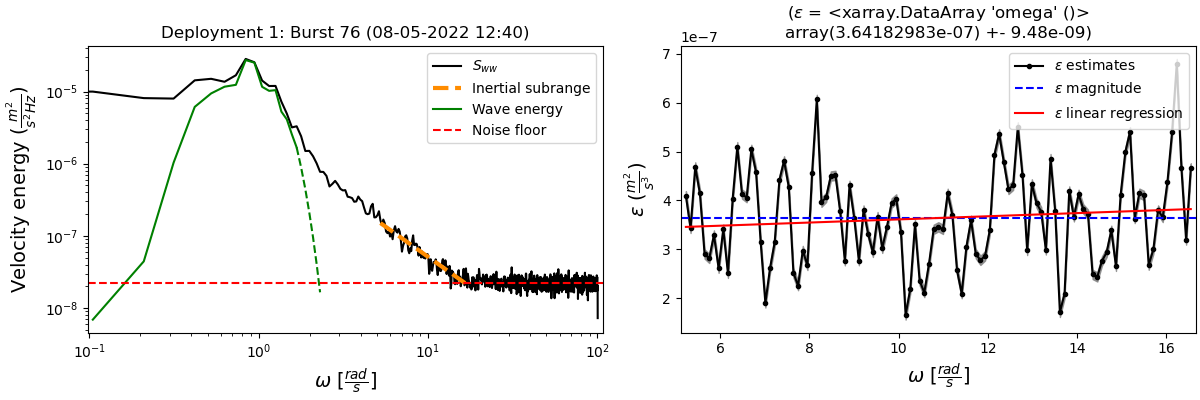

In [16]:
#Check how individual burst spectra look
epsDS = eps1.copy(deep=True)
burstList = [76]#bl.values
ds_sub = epsDS.where(epsDS.BurstCounter.isin(burstList),drop=True)

rows = len(burstList)
width = 12
height = 4 * rows
fig, axs = plt.subplots(rows, 2, constrained_layout=True,figsize=(width,height))

if rows == 1:
    lb = int(ds_sub.LowBound.values[0])
    ub = int(ds_sub.HighBound.values[0])
    epsMu = ds_sub.Mu.values[0]
    epsMuRound = np.round(epsMu,decimals=2)
    muFit = ds_sub.Int[0] * ds_sub.omega[lb:ub]**epsMu
    kolFit = ds_sub.KolFitInt[0] * ds_sub.omega[lb:ub]**(-5/3)

    axs[0].set_title('Deployment 1: Burst '+str(burstList[0])+' (08-05-2022 12:40)')#r' ($\epsilon_{\mu}$ = '+str(epsMuRound)+')')

    #Plot S_uv
    #axs[0].loglog(ds_sub.omega, (ds_sub.Suu[0]+ds_sub.Svv[0])/2, '-', color='Blue', label = '$S_{uv}$')

    #Plot S_ww
    axs[0].loglog(ds_sub.omega, ds_sub.Sww[0], '-k', label = r'$S_{ww}$')
    axs[0].loglog(ds_sub.omega[lb:ub], muFit, ls='--',color='darkorange', lw = 3, label = r'Inertial subrange')
    #axs.loglog(ds_sub.omega[lb:ub], kolFit, ls = '-.',color = 'Purple', label = 'Kolmogorov Law')

    #Plot S_w'w' without wavetail
    axs[0].loglog(ds_sub.omega[:int(ds_sub.WavetailStart.values[0])+1],ds_sub.SwwPrime[0][:int(ds_sub.WavetailStart.values[0])+1],
               '-g', label = "Wave energy")
    #Plot S_w'w' wavetail
    axs[0].loglog(ds_sub.omega[int(ds_sub.WavetailStart.values[0]):int(ds_sub.WavetailEnd.values[0])],
               ds_sub.SwwPrime[0][int(ds_sub.WavetailStart.values[0]):int(ds_sub.WavetailEnd.values[0])],
               '--g')#, label = r"$\omega^{-4}$ model")

    #Plot where the velocity noisefloor lies
    axs[0].axhline(y = ds_sub.VelocityNoisefloor.values[0], ls = '--', color = 'r', label = 'Noise floor')
    
    axs[0].margins(x=.01)
    axs[0].set_xlabel(r'$\omega$ $[\frac{rad}{s}]$', fontsize = 14)#('Frequency (Hz)', fontsize = 14)
    axs[0].set_ylabel(r'Velocity energy $(\frac{m^{2}}{s^{2}Hz})$', fontsize = 14)
    axs[0].legend(loc='upper right')
    
    #Next, set up the linear regression chart
    alpha = 1.5
    Jlm = ds_sub.J33.values[0]

    #Estimate turbulent dissipation (Epsilon/eps)
    isrOmega = ds_sub.omega[lb:ub] #Radian frequency range
    S33 = ds_sub.Sww.values[0][lb:ub] #Vertical velocity spectra within ISR

    #Dissipation formula (Eq. A14 from Gerbi et al., 2009)
    eps = ((S33 * (isrOmega**(5/3)))/(alpha * Jlm))**(3/2) #Returns array of eps estimates across ISR
    res = stats.linregress(isrOmega, eps)
    epsLR = ((res.slope*isrOmega) + res.intercept)

    i = 1
    while (res.pvalue<.05)&((ub-i)-lb>=60):
        isrOmega = ds_sub.omega[lb:ub-i] #Radian frequency range
        S33 = ds_sub.Sww.values[0][lb:ub-i] #Vertical velocity spectra within ISR
        eps = ((S33 * (isrOmega**(5/3)))/(alpha * Jlm))**(3/2) #Returns array of eps estimates across ISR
        res = stats.linregress(isrOmega, eps)
        epsLR = ((res.slope*isrOmega) + res.intercept)
        i=i+1
        print(res.pvalue,(ub-i)-lb)

    epsMag = np.mean(eps)
    #epsMag = ds_sub.eps.values[0]
    #epsMag = np.round(ds_sub.eps.values[0], decimals=9)
    epsErr = np.round(ds_sub.epsErr.values[0], decimals=11)
    
    lowerCI = eps.values - ds_sub.epsErr.values[0]
    upperCI = eps.values + ds_sub.epsErr.values[0]

    #res = stats.linregress(isrOmega, eps)
    #epsLR = ((res.slope*isrOmega) + res.intercept)
    axs[1].set_title(r'($\epsilon$ = '+str(epsMag)+' +- '+str(epsErr)+')')
    axs[1].plot(isrOmega, eps, '.-k', label = r'$\epsilon$ estimates')
    axs[1].fill_between(isrOmega, lowerCI, upperCI, color='gray', alpha=0.8)
    axs[1].axhline(y = epsMag, color = 'b', ls = '--', label = r'$\epsilon$ magnitude')
    axs[1].plot(isrOmega, epsLR.values, '-r', label = r'$\epsilon$ linear regression')
    axs[1].set_xlabel(r'$\omega$ $[\frac{rad}{s}]$', fontsize = 14)
    axs[1].set_ylabel(r'$\epsilon$ $(\frac{m^{2}}{s^{3}})$', fontsize=14)
    axs[1].margins(x=.01)
    axs[1].legend(loc='upper right')
else:
    for b in enumerate(burstList):
        lb = int(ds_sub.LowBound.values[b[0]])
        ub = int(ds_sub.HighBound.values[b[0]])
        epsMu = ds_sub.Mu.values[b[0]]
        epsMuRound = np.round(epsMu,decimals=2)
        muFit = (ds_sub.Int[b[0]] * ds_sub.omega[lb:ub]**epsMu)
        kolFit = ds_sub.KolFitInt[b[0]] * ds_sub.omega[lb:ub]**(-5/3)

        axs[b[0],0].set_title('Deployment 1: Burst '+str(b[1])+r' ($\epsilon_{\mu}$ = '+str(epsMuRound)+')')

        #Plot S_uv
        axs[b[0],0].loglog(ds_sub.omega, (ds_sub.Suu[b[0]]+ds_sub.Svv[b[0]])/2, '-', color='Blue', label = '$S_{uv}$')

        #Plot S_ww
        axs[b[0],0].loglog(ds_sub.omega, ds_sub.Sww[b[0]], '-k', label = r'$S_{ww}$')
        axs[b[0],0].loglog(ds_sub.omega[lb:ub], muFit, ls='--',color='darkorange', lw = 3, label = 'Power law fit')
        #axs.loglog(ds_sub.omega[lb:ub], kolFit, ls = '-.',color = 'Purple', label = 'Kolmogorov Law')

        #Plot S_w'w' without wavetail
        axs[b[0],0].loglog(ds_sub.omega[:int(ds_sub.WavetailStart.values[b[0]])+1],ds_sub.SwwPrime[b[0]][:int(ds_sub.WavetailStart.values[b[0]])+1],
                   '-g', label = r"$S_{w'w'}$")
        #Plot S_w'w' wavetail
        axs[b[0],0].loglog(ds_sub.omega[int(ds_sub.WavetailStart.values[b[0]]):int(ds_sub.WavetailEnd.values[b[0]])],
                   ds_sub.SwwPrime[b[0]][int(ds_sub.WavetailStart.values[b[0]]):int(ds_sub.WavetailEnd.values[b[0]])],
                   '--g', label = r"$\omega^{-4}$ model")

        #Plot where the velocity noisefloor lies
        axs[b[0],0].axhline(y = ds_sub.VelocityNoisefloor.values[b[0]], ls = '--', color = 'r', label = 'Noise floor')

        axs[b[0],0].margins(x=.01)
        axs[b[0],0].set_xlabel(r'$\omega$ $(\frac{rads}{s})$', fontsize = 14)
        axs[b[0],0].set_ylabel(r'PSD $(\frac{m^{2}}{s^{2}})/(\frac{rads}{s})$', fontsize=14)
        if b[0] == 0:
            axs[b[0],0].legend(loc='upper right')

        #Next, set up the linear regression chart
        alpha = 1.5
        Jlm = ds_sub.J33.values[b[0]]

        #Estimate turbulent dissipation (Epsilon/eps)
        isrOmega = ds_sub.omega[lb:ub] #Radian frequency range
        S33 = ds_sub.Sww.values[b[0]][lb:ub] #Vertical velocity spectra within ISR

        #Dissipation formula (Eq. A14 from Gerbi et al., 2009)
        eps = ((S33 * (isrOmega**(5/3)))/(alpha * Jlm))**(3/2) #Returns array of eps estimates across ISR
        res = stats.linregress(isrOmega, eps)
        epsLR = ((res.slope*isrOmega) + res.intercept)
        
        i = 1
        while (res.pvalue<.05)&((ub-i)-lb>=60):
            isrOmega = ds_sub.omega[lb:ub-i] #Radian frequency range
            S33 = ds_sub.Sww.values[b[0]][lb:ub-i] #Vertical velocity spectra within ISR
            eps = ((S33 * (isrOmega**(5/3)))/(alpha * Jlm))**(3/2) #Returns array of eps estimates across ISR
            res = stats.linregress(isrOmega, eps)
            epsLR = ((res.slope*isrOmega) + res.intercept)
            i=i+1
            print(res.pvalue,(ub-i)-lb)

        epsMag = np.mean(eps)
        #epsMag = np.round(ds_sub.eps.values[b[0]], decimals=9)
        epsErr = np.round(ds_sub.epsErr.values[b[0]], decimals=11)

        lowerCI = eps.values - ds_sub.epsErr.values[b[0]]
        upperCI = eps.values + ds_sub.epsErr.values[b[0]]

        
        axs[b[0],1].set_title(r'($\epsilon$ = '+str(epsMag)+' +- '+str(epsErr)+')')
        axs[b[0],1].plot(isrOmega, eps, '.-k', label = r'$\epsilon$ estimates')
        axs[b[0],1].fill_between(isrOmega, lowerCI, upperCI, color='gray', alpha=0.8)
        axs[b[0],1].axhline(y = epsMag, color = 'b', ls = '--', label = r'$\epsilon$ magnitude')
        axs[b[0],1].plot(isrOmega, epsLR.values, '-r', label = r'$\epsilon$ linear regression')
        axs[b[0],1].set_xlabel(r'$\omega$ $(\frac{rads}{s})$', fontsize = 14)
        axs[b[0],1].set_ylabel(r'$\epsilon$ $(\frac{m^{2}}{s^{3}})$', fontsize=14)
        axs[b[0],1].margins(x=.01)
        if b[0]==0:
            axs[b[0],1].legend(loc='upper right')

#plt.savefig('Figures/Burst76_spectra.png')

### Overview of deployment 1
Deployment 1 of the ADV spans the course of August 2nd to August 12th in 2022. The temperature profile of the water column during the first half of the deployment shows a trend of increasing temperature until reaching a peak on the 6th. After this temperature peak, there is a general decrease in temperature over time. Diurnal temperature drops are relatively small in the first half of the deployment when compared to the latter half. While these smaller cooling events appear as noise when compared to the rest of the temperature time series, the primary velocities from the ADV show significant onshore currents. Starting around the 5th, the cooling events grow more dramatic, with steeper declines in temperature and sharp transitions from offshore to onshore transport by magnitudes of up to .3[m/s] The most intense cooling events in terms of temperature drop and onshore velocity occur just after the 6th, middle of the 7th, and middle of the 8th. These cooling events yield the largest estimates of turbulent kinetic energy dissipation rate ($\epsilon$), indicating that the rapid influx of cool, offshore water into the kelp forest has a noticeable effect on turbulence. Beyond the middle of the 8th, data from the ADV became inconsistent with high correlation and signal-to-noise ratios, invalidating most $\epsilon$ measurements towards the end of the deployment.